In [1]:
import numpy as np
import copy
import random
import operator
import re
import math
from functools import reduce
# import MC_MODEL as mc
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
stopwords = [
# 	"i",          "me",         "my",         "myself",     "we",        
# 	"our",        "ours",       "ourselves",  "you",        "your",      
# 	"yours",      "yourself",   "yourselves", "he",         "him",       
# 	"his",        "himself",    "she",        "her",        "hers",      
# 	"herself",    "it",         "its",        "itself",     "they",      
# 	"them",       "their",      "theirs",     "themselves", "what",      
# 	"which",      "who",        "whom",       "this",       "that",      
# 	"these",      "those",      "am",         "is",         "are",       
# 	"was",        "were",       "be",         "been",       "being",     
# 	"have",       "has",        "had",        "having",     "do",        
# 	"does",       "did",        "doing",      "would",      "should",    
# 	"could",      "ought",      "i'm",        "you're",     "he's",      
# 	"she's",      "it's",       "we're",      "they're",    "i've",      
# 	"you've",     "we've",      "they've",    "i'd",        "you'd",     
# 	"he'd",       "she'd",      "we'd",       "they'd",     "i'll",      
# 	"you'll",     "he'll",      "she'll",     "we'll",      "they'll",   
# 	"isn't",      "aren't",     "wasn't",     "weren't",    "hasn't",    
# 	"haven't",    "hadn't",     "doesn't",    "don't",      "didn't",    
# 	"won't",      "wouldn't",   "shan't",     "shouldn't",  "can't",     
# 	"cannot",     "couldn't",   "mustn't",    "let's",      "that's",    
# 	"who's",      "what's",     "here's",     "there's",    "when's",    
# 	"where's",    "why's",      "how's",      "a",          "an",        
# 	"the",        "and",        "but",        "if",         "or",        
# 	"because",    "as",         "until",      "while",      "of",        
# 	"at",         "by",         "for",        "with",       "about",     
# 	"against",    "between",    "into",       "through",    "during",    
# 	"before",     "after",      "above",      "below",      "to",        
# 	"from",       "up",         "down",       "in",         "out",       
# 	"on",         "off",        "over",       "under",      "again",     
# 	"further",    "then",       "once",       "here",       "there",     
# 	"when",       "where",      "why",        "how",        "all",       
# 	"any",        "both",       "each",       "few",        "more",      
# 	"most",       "other",      "some",       "such",       "no",        
# 	"nor",        "not",        "only",       "own",        "same",      
# 	"so",         "than",       "too",        "very",       "will"
]

In [3]:
def clean(string):
	string = re.sub('<sssss>' , ' ', string)
# 	string = re.sub('- *[lr]rb *-', ' ', string)
# 	string = re.sub('(^| )http:[^ ]+', ' ', string)
# 	string = re.sub('(^| )[A-Za-z]( |$)', ' ', string)
# 	string = re.sub('(^| )\'[^ ]+', ' ', string)
# 	string = re.sub('(^| )n\'t ', ' ', string)
# 	string = re.sub('[^A-Za-z !?/]+', '', string)
# 	string = re.sub('(^| )[A-Za-z]( |$)', ' ', string)
	string = re.sub('/', ' ', string)
	return string

In [42]:
def readData(fpath):
    file = open(fpath, encoding='UTF-8')
    label, sentences, voc = [], [], []
    for line in file:
        l = line.split('\t\t')
        label.append(l[0])
        sen = clean(l[1])
        sen = list(filter(lambda y:y not in stopwords, sen.split()))
        sen = list(filter(lambda x:x, sen))
#         sentences.append(sen if sen else ['qwerty'])
        voc += sen
    file.close()
    return label, sentences, voc

In [6]:
file = open('wordvec_6B_50d.txt', encoding='UTF-8')
vec, wdvec_dict, order = [], {}, 0
for line in file:
	item = line.strip().split()
	vec.append(list(map(float,item[1:])))
	wdvec_dict[item[0]] = order
	order += 1
file.close()
def w2v(word):
    if (word in wdvec_dict):
        return np.array(vec[wdvec_dict[word]])
    return np.zeros(50)

In [43]:
label, train_sen, t_voc = readData('MulLabelTrain.ss')
_, test_sen, test_voc = readData('MulLabelTest.ss')
vlabel, valid_sen, valid_voc = readData('SmallValid.ss')

In [44]:
train_x = []
for ts in train_sen:
    v = np.array(list(map(w2v,ts))).mean(axis=0)
    train_x.append(v)
train_x = np.array(train_x)
test_x = []
for ts in test_sen:
    v = np.array(list(map(w2v,ts))).mean(axis=0)
    test_x.append(v)
test_x = np.array(test_x)

In [45]:
valid_x = []
for ts in valid_sen:
    v = np.array(list(map(w2v,ts))).mean(axis=0)
    valid_x.append(v)
valid_x = np.array(valid_x)

In [46]:
x0 = np.ones((train_x.shape[0],1))
train_x = np.concatenate((x0, train_x), axis=1)
x0 = np.ones((test_x.shape[0], 1))
test_x = np.concatenate((x0, test_x), axis=1)
x0 = np.ones((valid_x.shape[0], 1))
valid_x = np.concatenate((x0, valid_x), axis=1)

In [47]:
def dist_Train_test(train_X, label, test_item):
	dist = train_X - test_item
	dist = np.sum(dist * dist, axis=1)
	item = zip(dist, label)
	return sorted(item, key=lambda x:x[0], reverse=True)

def evaluate(TP, FN, TN, FP):
	Accuracy = (TP + TN) / np.float64(TP + FP + TN + FN)
	return Accuracy
def check(res, std):
	count = [0]*4
	for r, s in zip(res, std):
		wrong = int(r != s)
		neg = int(s != 1)
		count[neg * 2 + wrong] += 1
	print(evaluate(*count))
	return 
def sigmoid(X):
	return 1 / (1 + np.exp(-X))
class LogicalRegression(object):
	"""docstring for LogicalRegression"""
	def __init__(self, train_X, train_y, weights=None, times=1000, alpha=0.01, c=2, style='batch'):
		self.train_X = train_X
		self.train_y = train_y
		self.times = times
		self.alpha = alpha
		self.c = c
		gradient = []
		if weights == None:
			weights = np.zeros((1,train_X.shape[1])) # 1*M
		# alpha = 0.000001
		epsilon = 1e-5
		self.w0 = weights.T # M*1
		p = sigmoid(np.dot(train_X, self.w0)) # N*M X M*1 = N*1
		J0 = self.logistic_cost(p, train_y)
		K0 = K00 = J0
		for t in range(times):
			p_y = p - train_y
			w = self.w0 - alpha * np.dot(train_X.T, p_y) 
			# print(np.dot(train_X.transpose(), p_y))
			gradient.append(np.sum(-np.dot(train_X.T, p_y)))
			# w = self.w0 - alpha * np.dot(train_X.transpose(), p_y) / len(p) - lambda_ * self.w0 / len(p) #40*1
			p = sigmoid(np.dot(train_X, w))
			J = self.logistic_cost(p, train_y)
			if t > 7 and K00 == J:
				break
			K00 = K0
			K0 = J
			if J < J0: # not convergent
				J0 = J
				self.w0 = w
			else:
				alpha /= c
				if np.linalg.norm(w - self.w0) < epsilon * np.linalg.norm(self.w0):
					# print('times: ', t)
					break
		return # M*1
	def LR(self, train_X, train_y,weights=None):
		gradient = []
		if weights == None:
			weights = np.zeros((1,train_X.shape[1])) # 1*M
		# alpha = 0.000001
		epsilon = 1e-3
		w0 = weights.T # M*1
		# print(w0)
		p = sigmoid(np.dot(train_X, w0)) # N*M X M*1 = N*1
		J0 = self.logistic_cost(p, train_y)
		K0 = K00 = J0
		for t in range(self.times):
			p_y = p - train_y
			w = w0 - self.alpha * np.dot(train_X.T, p_y) 
			# print(np.dot(train_X.transpose(), p_y))
			gradient.append(np.sum(-np.dot(train_X.T, p_y)))
			# w = w0 - alpha * np.dot(train_X.transpose(), p_y) / len(p) - lambda_ * w0 / len(p) #40*1
			p = sigmoid(np.dot(train_X, w))
			J = self.logistic_cost(p, train_y)
			if t > 7 and K00 == J:
				break
			K00 = K0
			K0 = J
			if J < J0: # not convergent
				J0 = J
				w0 = w
			else:
				self.alpha /= self.c
				if np.linalg.norm(w - w0) < epsilon * np.linalg.norm(w0):
					# print('times: ', t)
					break
		return w0 # M*1
	def logistic_cost(self, p, train_y):
		_p = copy.deepcopy(p)
		_p[train_y == 0] = 1 - _p[train_y == 0]
		return -sum(np.log(_p+0.000001)) 
	def predict(self, test_X):
		return  sigmoid(np.dot(test_X, self.w0))
	def groupValidation(self, k=10):
		n = self.train_X.shape[0]
		m = math.ceil(n/k)
		n_id = list(range(n))
		random.shuffle(n_id)
		L = []
		L += list(map(lambda x:n_id[x:x+m] ,map(lambda i:i*m, range(10))))
		return L
	def crossValidation(self):
		L = self.groupValidation()
		for i in range(len(L)):
			cp_L = copy.deepcopy(L)
			vali_id = cp_L.pop(i)
			vali_X, vali_y = self.train_X[vali_id], self.train_y[vali_id]
			tra_x, tra_y = self.train_X[reduce(operator.add,cp_L)], self.train_y[reduce(operator.add,cp_L)]
			weights = self.LR(tra_x, tra_y)
			res = np.dot(vali_X, weights)
			res = list(map(lambda x: 1 if x > 0 else 0, res))
			check(res, vali_y)
		return

In [48]:
def writefile(filename, res):
    file = open(filename,'w')
    for i in res:
        file.write(i+'\n')
    file.close()
    return
def check_label(std, res):
    return (np.array(res) == np.array(std)).sum() / len(std)
def labelTonum(label):
    L_y = list(map(lambda x:1 if x =='LOW' else 0, label))
    L_y = np.array([L_y]).T
    M_y = list(map(lambda x:1 if x =='MID' else 0, label))
    M_y = np.array([M_y]).T
    H_y = list(map(lambda x:1 if x =='HIG' else 0, label))
    H_y = np.array([H_y]).T
    return L_y, M_y, H_y
def numTolabel(y):
    name = ['LOW','MID','HIG']
    return list(map(lambda x:name[x],y))
def samplebalance(label, train, length,start=0):
    l = list(map(lambda x:x[1] ,filter(lambda x: x[0]=='LOW',zip(label,range(len(label))))))
    m = list(map(lambda x:x[1] ,filter(lambda x: x[0]=='MID',zip(label,range(len(label))))))
    h = list(map(lambda x:x[1] ,filter(lambda x: x[0]=='HIG',zip(label,range(len(label))))))
    index = l[start:length+start] + m[start:length+start] + h[start:length+start] 
    label_ = list(map(lambda x: label[x],index))
    train_ = np.array(list(map(lambda x: train_x[x],index)))
    return label_, train_

In [49]:
####################################KNN Validtion##########################
slabel, strain_x = samplebalance(label, train_x,2000)
K = [1,3,4,5,112]
bag = []
ac = 0
for k in K:
    KNN_pred = []
    for item in valid_x:
        NN = dist_Train_test(strain_x, slabel, item)
        KNN_pred += [Counter(list(map(lambda x:x[1],NN[:k]))).most_common(1)[0][0]]
#         ac = check_label(KNN_pred, vlabel)
#         if check_label(KNN_pred, vlabel) > 0.4:
    bag.append(KNN_pred)
    print(check_label(KNN_pred, vlabel))
####################################KNN Validtion##########################

0.398
0.468
0.468
0.468
0.258


In [50]:
*bag

SyntaxError: can't use starred expression here (<ipython-input-50-23c75949ee23>, line 1)

In [22]:
####################################KNN Validtion##########################
slabel, strain_x = samplebalance(label, train_x,2000,2000)
K = [1,2,3,4,5,6,7,10,15,20,30,40,70,90,100,111,112]
for k in K:
    KNN_pred = []
    for item in valid_x:
        NN = dist_Train_test(strain_x, slabel, item)
        KNN_pred += [Counter(list(map(lambda x:x[1],NN[:k]))).most_common(1)[0][0]]
    print(check_label(KNN_pred, vlabel))
####################################KNN Validtion##########################

0.262
0.262
0.262
0.262
0.262
0.262
0.264
0.206
0.242
0.234
0.256
0.264
0.266
0.266
0.266
0.266
0.266


In [ ]:
###################################LR Validtion############################
x0 = np.ones((strain_x.shape[0],1))
stx = np.concatenate((x0, strain_x), axis=1)
x0 = np.ones((valid_x.shape[0], 1))
vx = np.concatenate((x0, valid_x), axis=1)
L_y, M_y, H_y = labelTonum(slabel)
model_L = LogicalRegression(stx, L_y)
model_M = LogicalRegression(stx, M_y)
model_H = LogicalRegression(stx, H_y)
pred_L = model_L.predict(vx)
pred_M = model_M.predict(vx)
pred_H = model_H.predict(vx)
pred = np.concatenate((pred_L, pred_M, pred_H), axis=1)
_res = pred.argmax(axis=1)
res = numTolabel(_res)
check_label(res, vlabel)
###################################LR Validtion############################

In [1]:
###################################KNN test################################
K = 2
KNN_pred = []
for item in test_x:
    NN = dist_Train_test(train_x, label, item)
    KNN_pred += [Counter(list(map(lambda x:x[1],NN[:K]))).most_common(1)[0][0]]
writefile('KNN.csv', KNN_pred)
###################################KNN test################################

NameError: name 'test_x' is not defined

In [ ]:
###################################LR test################################
x0 = np.ones((train_x.shape[0],1))
trainx = np.concatenate((x0, train_x), axis=1)
x0 = np.ones((test_x.shape[0], 1))
testx = np.concatenate((x0, test_x), axis=1)

L_y, M_y, H_y = labelTonum(label)
model_L = LogicalRegression(trainx, L_y)
model_M = LogicalRegression(trainx, M_y)
model_H = LogicalRegression(trainx, H_y)
pred_L = model_L.predict(testx)
pred_M = model_M.predict(testx)
pred_H = model_H.predict(testx)
pred = np.concatenate((pred_L, pred_M, pred_H), axis=1)
_res = pred.argmax(axis=1)
LR_pred = numTolabel(_res)
writefile('LR.csv', LR_pred)
###################################LR test################################

In [34]:
pred = np.concatenate((pred_L, pred_M, pred_H), axis=1)
# plt.scatter(range(len(pred.argmax(axis=1))), pred.argmax(axis=1))
# plt.show()
# plt.hist( pred.argmax(axis=1))
# plt.show()
_res = pred.argmax(axis=1)
L_name = ['LOW','MID','HIG']
res = list(map(lambda x:L_name[x], _res))

# pred_L0 = model_L.predict(train_x[:500])
# pred_M0 = model_M.predict(train_x[:500])
# pred_H0 = model_H.predict(train_x[:500])
# pred0 = np.concatenate((pred_L0, pred_M0, pred_H0), axis=1)
# _res = pred0.argmax(axis=1)

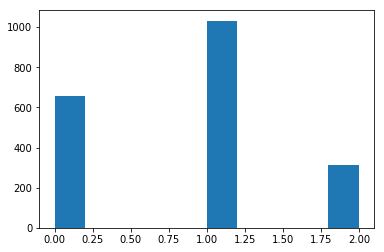

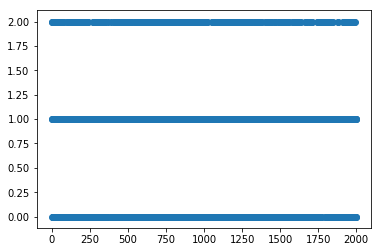

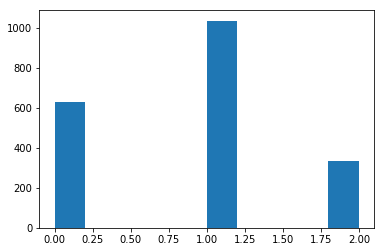

In [41]:
# _res = pred0.argmax(axis=1)
# res = []
# for i in _res[:500]:
#     if i == 0:
#         res += ['LOW']
#     elif i== 1:
#         res += ['MID']
#     else :
#         res += ['HIG']
# check(res,label[:500])

0.562
